# Training For STARE

### Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
import os
import skimage.io as io
import skimage.transform as trans
import shutil
import cv2
import matplotlib.pyplot as plt
import pickle
import time
from __future__ import print_function
import glob
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.models import load_model as load_initial_model
from google.colab.patches import cv2_imshow
import gc

### Handcrafted Metrics For Additional Evaluation

In [ ]:
def dice_coef(y_true, y_pred):
  smooth = 0.0
  y_true_f = keras.flatten(y_true)
  y_pred_f = keras.flatten(y_pred)
  intersection = keras.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

  y_true_f = keras.flatten(y_true)
  y_pred_f = keras.flatten(y_pred)
  intersection = keras.sum ( y_true_f * y_pred_f)
  union = keras.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

  return intersection/union

### The Model

In [ ]:
def unet(pretrained_weights = None,input_size = (608,704,1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs,conv10)

  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',dice_coef,jacard, tf.keras.metrics.AUC(), tf.keras.metrics.MeanIoU(num_classes=2),
                                                                                      tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
  #model.summary()

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

### Generators

In [ ]:
def adjustData(img,mask,flag_multi_class,num_class):
  if(flag_multi_class):
    img = img / 255
    mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
    new_mask = np.zeros(mask.shape + (num_class,))
    for i in range(num_class):
        #for one pixel in the image, find the class in mask and convert it into one-hot vector
        #index = np.where(mask == i)
        #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
        #new_mask[index_mask] = 1
        new_mask[mask == i,i] = 1
    new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
    mask = new_mask
  elif (np.max(img) > 1):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
  return (img,mask)

In [ ]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (608,704),seed = 1):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  image_generator = image_datagen.flow_from_directory(
      train_path,
      classes = [image_folder],
      class_mode = None,
      color_mode = image_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = image_save_prefix,
      seed = seed)
  mask_generator = mask_datagen.flow_from_directory(
      train_path,
      classes = [mask_folder],
      class_mode = None,
      color_mode = mask_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = mask_save_prefix,
      seed = seed)
  train_generator = zip(image_generator, mask_generator)
  for (img,mask) in train_generator:
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    yield (img,mask)

In [ ]:
def testGenerator(KFOLD_TEMP_TEST, target_size = (608,704),flag_multi_class = False,as_gray = True):
  image_datagen = ImageDataGenerator(rescale=1./255)
  mask_datagen = ImageDataGenerator(rescale=1./255)

  for img_name in sorted(os.listdir(KFOLD_TEMP_TEST + "/images")):
      img = io.imread(os.path.join(KFOLD_TEMP_TEST + "/images",img_name),as_gray = as_gray)
      img = img / 255
      img = trans.resize(img,target_size)
      img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
      img = np.reshape(img,(1,)+img.shape)
      yield img

In [ ]:
def testGenerator2(batch_size,test_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (608,704),seed = 1):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  image_generator = image_datagen.flow_from_directory(
      test_path,
      classes = [image_folder],
      class_mode = None,
      color_mode = image_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = image_save_prefix,
      seed = seed)
  mask_generator = mask_datagen.flow_from_directory(
      test_path,
      classes = [mask_folder],
      class_mode = None,
      color_mode = mask_color_mode,
      target_size = target_size,
      batch_size = batch_size,
      save_to_dir = save_to_dir,
      save_prefix  = mask_save_prefix,
      seed = seed)
  test_generator = zip(image_generator, mask_generator)
  for (img,mask) in test_generator:
    img,mask = adjustData(img,mask,flag_multi_class,num_class)
    yield (img,mask)

### Utils

In [ ]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

In [ ]:
def saveResult(fold,k,save_path,npyfile,flag_multi_class = False,num_class = 2):
  for i,item in enumerate(npyfile):
      img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
      io.imsave(os.path.join(save_path,"%d_predict.png"%(i+fold*k)),img)

## K-FOLD Training

### The Training Function
* This function includes mkdir temporary directories and training module. 
* Global path variables defined below. 
* We recommend you that do not configure your code, configure your drive paths.
* If you launch this function one more time or more, you must delete files in RESULTS_PATH.

In [ ]:
"""
TRAIN_PATH_IMG  -> 30 img + augmented imgs (not k-fold cross validated)
TRAIN_PATH_MASK -> 30 mask + augmented masks (not k-fold cross validated)

KFOLD_TEMP_TRAIN -> Contains k-fold cross validated train images and masks
KFOLD_TEMP_TEST -> Contains k-fold cross validated test images and masks

LOG_PATH -> contains model history with pickle files
CKPTS_PATH -> for checkpoints
RESULTS_PATH -> containts predictions

You should create below paths by hand. We recommend you that do not configure your code, configure your paths.
When you launch all cells again, delete every file in RESULTS_PATH.
"""

TRAIN_PATH_IMG        = '/content/drive/MyDrive/AI_Projects/STARE/combinations_png/B/images' 
TRAIN_PATH_MASK       = '/content/drive/MyDrive/AI_Projects/STARE/combinations_png/B/labels'
KFOLD_TEMP_TRAIN      = '/content/drive/MyDrive/AI_Projects/STARE/kfold_B/temp_train'
KFOLD_TEMP_TEST       = '/content/drive/MyDrive/AI_Projects/STARE/kfold_B/temp_test'

LOG_PATH   = '/content/drive/MyDrive/AI_Projects/STARE/kfold_B/logs'
CKPTS_PATH = '/content/drive/MyDrive/AI_Projects/STARE/kfold_B/checkpoints'
RESULTS_PATH = '/content/drive/MyDrive/AI_Projects/STARE/kfold_B/results'


if (os.path.isdir(TRAIN_PATH_IMG) and os.path.isdir(TRAIN_PATH_MASK) and \
    os.path.isdir(KFOLD_TEMP_TRAIN) and os.path.isdir(KFOLD_TEMP_TEST) and os.path.isdir(LOG_PATH) and \
    os.path.isdir(CKPTS_PATH) and os.path.isdir(RESULTS_PATH)) == 0:
    raise OSError()

In [ ]:
def k_fold(epoch, start, train_batch_size, test_batch_size, train_sample_number, test_sample_number, initial_model_path, k=5,show_samples=False):
  """
  Parameters:
    - epoch: nof epochs for each fold
    - train_batch_size: batch size for training
    - test_batch_size: batch size for test
    - k: I HAVE K SAMPLES IN TEST AND 30+AUGMENTED-K SAMPLES IN TRAIN 
          for example if you didn't make augmentation, and choose k=5
          you have 5 images in test and 25 images in train.
          function iterates folds.
    - show_samples: show ground truth predictions pairs 
  """

  assert 20 % k ==0, "Number of images divided by fold number must be integer."
  NOF_PLOTS = 0
  for i in range(start, int(20/k), 1):
    test_images_temp = [j for j in range(k)]
    test_images_temp_2 = [a + i*k for a in test_images_temp]
    test_images = [str(a) for a in test_images_temp_2] #our test ids
    print("Test images: {}".format(test_images))

    shutil.rmtree(KFOLD_TEMP_TRAIN, ignore_errors=False, onerror=None)
    os.mkdir(KFOLD_TEMP_TRAIN)
    os.mkdir(KFOLD_TEMP_TRAIN + "/images")
    os.mkdir(KFOLD_TEMP_TRAIN + "/labels")

    shutil.rmtree(KFOLD_TEMP_TEST, ignore_errors=False, onerror=None)
    os.mkdir(KFOLD_TEMP_TEST)
    os.mkdir(KFOLD_TEMP_TEST + "/images")
    os.mkdir(KFOLD_TEMP_TEST + "/labels")

    for test_image in test_images: #allocates test images into the path
      src = TRAIN_PATH_IMG + "/" + test_image + ".png"
      shutil.copy(src, KFOLD_TEMP_TEST + "/images")

      src = TRAIN_PATH_MASK + "/" + test_image + ".png"
      shutil.copy(src, KFOLD_TEMP_TEST + "/labels")

    for img in sorted(os.listdir(TRAIN_PATH_IMG)): #allocates train images into the path
      img_splitted_1 = img.split("_")
      img_splitted_2 = img.split(".")
      if (img_splitted_1[-1].split(".")[0] not in test_images) and (img_splitted_2[0] not in test_images):
        src = TRAIN_PATH_IMG + "/" + img
        shutil.copy(src, KFOLD_TEMP_TRAIN + "/images")

        src = TRAIN_PATH_MASK + "/" + img
        shutil.copy(src, KFOLD_TEMP_TRAIN + "/labels")

    data_gen_args = dict()
    train_generator = trainGenerator(train_batch_size,KFOLD_TEMP_TRAIN,'images','labels',data_gen_args,save_to_dir = None)
    test_generator = testGenerator2(test_batch_size,KFOLD_TEMP_TEST,'images','labels',data_gen_args,save_to_dir = None)

    model = unet()
    if initial_model_path != None:
      model.load_weights(initial_model_path)
    
    model_checkpoint = ModelCheckpoint(CKPTS_PATH + "/fold_{}_unet_stare.hdf5".format(i), monitor='loss',verbose=1, save_best_only=True)
    model_history = model.fit_generator(train_generator,steps_per_epoch=train_sample_number//train_batch_size,epochs=epoch,
                                        callbacks=[model_checkpoint],validation_data=test_generator,validation_steps=test_sample_number//test_batch_size)
    
    log_file = open(LOG_PATH + "/log_fold_{}.pkl".format(i), "wb")#history file
    pickle.dump(model_history.history, log_file)
    log_file.close()

    test_generator_2 = testGenerator(KFOLD_TEMP_TEST)
    results = model.predict_generator(test_generator_2,k,verbose=1)
    saveResult(i,k,RESULTS_PATH,results)

    time.sleep(10)
    # we dont know if time.sleep is the solution
    # but keep it
    del model
    gc.collect()

    # worst-practice visualization code. since our plots are dynamic, figsize of (17,17)
    # can be small for towards the end folds. You can make figsize = (17 + NOF_PLOTS, 17 + NOF_PLOTS) for bigger plots
    if show_samples:
      fig, axs = plt.subplots(k + NOF_PLOTS,3,figsize=(17,17))
      for idx,item in enumerate(sorted(os.listdir(RESULTS_PATH))):
        item_without_predict = item.split("_")[0] + ".png"
        img_real = cv2.imread(TRAIN_PATH_IMG + "/" + item_without_predict)
        img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
        #print(TRAIN_PATH_IMG + "/" + item_without_predict)
        #print(os.path.isfile(TRAIN_PATH_IMG + "/" + item_without_predict))
        img_ground_truth = cv2.imread(TRAIN_PATH_MASK + "/" + item_without_predict)
        img_ground_truth = cv2.cvtColor(img_ground_truth, cv2.COLOR_BGR2RGB) 
        img_predict = cv2.imread(RESULTS_PATH + "/" + item)
        img_predict = cv2.cvtColor(img_predict, cv2.COLOR_BGR2RGB)

        axs[idx,0].imshow(img_real)
        axs[idx,0].title.set_text('image_{}'.format(item_without_predict))
        axs[idx,1].imshow(img_ground_truth)
        axs[idx,1].title.set_text('ground truth')
        axs[idx,2].imshow(img_predict)
        axs[idx,2].title.set_text('predicted')
      plt.show()
      NOF_PLOTS += k

In [ ]:
k = 4
epoch = 10
train_sample_number = len(os.listdir(TRAIN_PATH_MASK)) - (len(os.listdir(TRAIN_PATH_MASK))//20*k)
print(train_sample_number)
INITIAL_MODEL_PATH = '/content/drive/MyDrive/AI_Projects/retina_DRIVE/U-Net/models/A_gamma_album_15epoch.hdf5' # you can give it just 'None'

Test images: ['0', '1', '2', '3']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 1696 images belonging to 1 classes.
Found 1696 images belonging to 1 classes.
565/565 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9355 - dice_coef: 0.5564 - jacard: 0.3940 - auc_1: 0.9304 - mean_io_u_1: 0.4451 - precision_1: 0.7727 - recall_1: 0.5739Found 4 images belonging to 1 classes.
Found 4 images belonging to 1 classes.
565/565 [==============================] - 928s 2s/step - loss: 0.1751 - accuracy: 0.9355 - dice_coef: 0.5565 - jacard: 0.3941 - auc_1: 0.9304 - mean_io_u_1: 0.4451 - precision_1: 0.7728 - recall_1: 0.5741 - val_loss: 0.1286 - val_accuracy: 0.9511 - val_dice_coef: 0.5755 - val_jacard: 0.4040 - val_auc_1: 0.9534 - val_mean_io_u_1: 0.4633 - val_precision_1: 0.6681 - val_recall_1: 0.6615

Epoch 00001: loss improved from inf to 0.15288, saving model to /content/drive/MyDrive/AI_Projects/STARE/kfold_B/checkpoints/fold_0_unet_stare.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


4/4 [==============================] - 1s 228ms/step


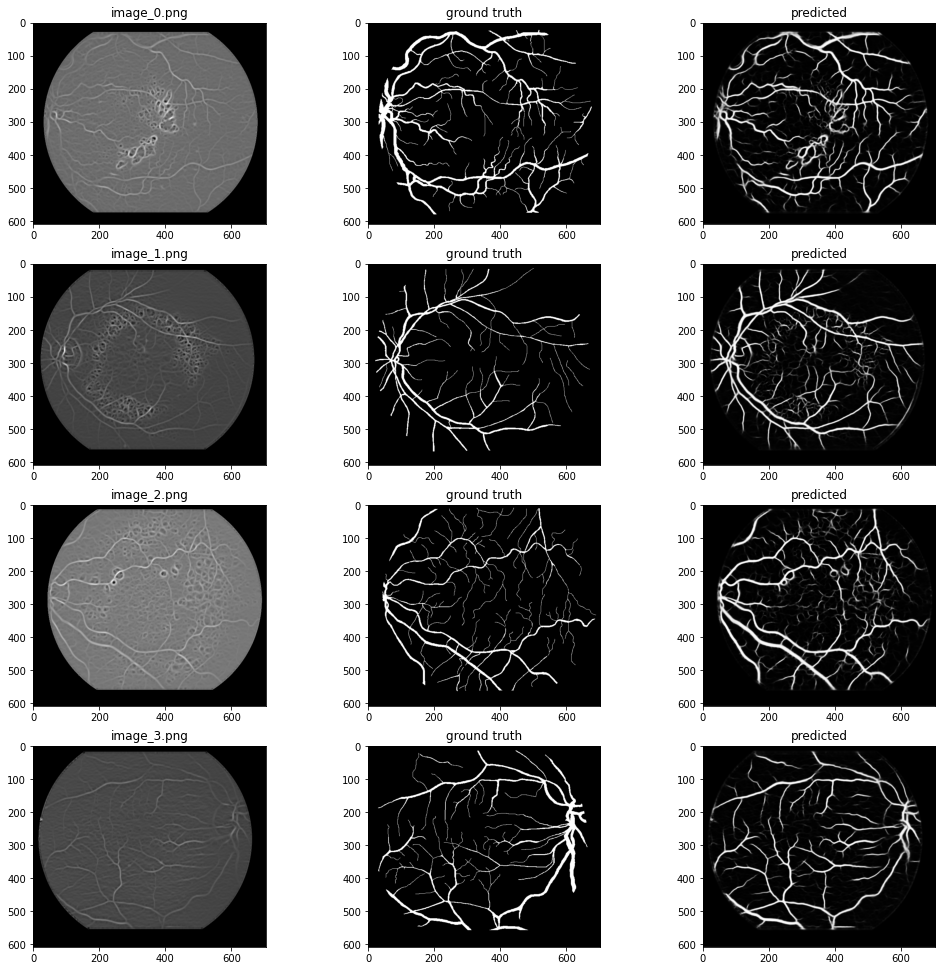

Test images: ['4', '5', '6', '7']
Found 1696 images belonging to 1 classes.
Found 1696 images belonging to 1 classes.
565/565 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9382 - dice_coef: 0.5227 - jacard: 0.3614 - auc_2: 0.9263 - mean_io_u_2: 0.4511 - precision_2: 0.7537 - recall_2: 0.5402Found 4 images belonging to 1 classes.
Found 4 images belonging to 1 classes.
565/565 [==============================] - 928s 2s/step - loss: 0.1702 - accuracy: 0.9382 - dice_coef: 0.5227 - jacard: 0.3615 - auc_2: 0.9264 - mean_io_u_2: 0.4511 - precision_2: 0.7538 - recall_2: 0.5403 - val_loss: 0.1507 - val_accuracy: 0.9458 - val_dice_coef: 0.6477 - val_jacard: 0.4790 - val_auc_2: 0.9576 - val_mean_io_u_2: 0.4386 - val_precision_2: 0.9164 - val_recall_2: 0.6144

Epoch 00001: loss improved from inf to 0.14841, saving model to /content/drive/MyDrive/AI_Projects/STARE/kfold_B/checkpoints/fold_1_unet_stare.hdf5
4/4 [==============================] - 1s 219ms/step


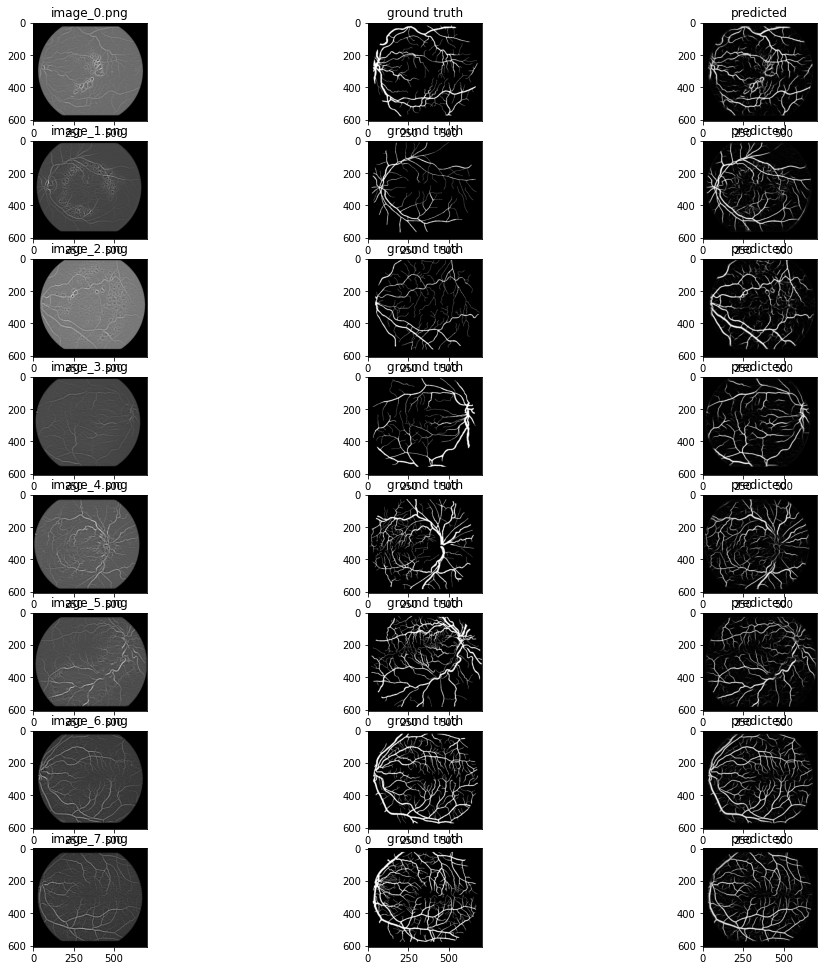

Test images: ['8', '9', '10', '11']
Found 1696 images belonging to 1 classes.
Found 1696 images belonging to 1 classes.
565/565 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9357 - dice_coef: 0.5175 - jacard: 0.3562 - auc_3: 0.9215 - mean_io_u_3: 0.4497 - precision_3: 0.7486 - recall_3: 0.5374Found 4 images belonging to 1 classes.
Found 4 images belonging to 1 classes.
565/565 [==============================] - 930s 2s/step - loss: 0.1806 - accuracy: 0.9357 - dice_coef: 0.5176 - jacard: 0.3563 - auc_3: 0.9215 - mean_io_u_3: 0.4497 - precision_3: 0.7487 - recall_3: 0.5375 - val_loss: 0.1797 - val_accuracy: 0.9366 - val_dice_coef: 0.6326 - val_jacard: 0.4627 - val_auc_3: 0.9493 - val_mean_io_u_3: 0.4357 - val_precision_3: 0.9230 - val_recall_3: 0.5532

Epoch 00001: loss improved from inf to 0.15451, saving model to /content/drive/MyDrive/AI_Projects/STARE/kfold_B/checkpoints/fold_2_unet_stare.hdf5
4/4 [==============================] - 1s 223ms/step


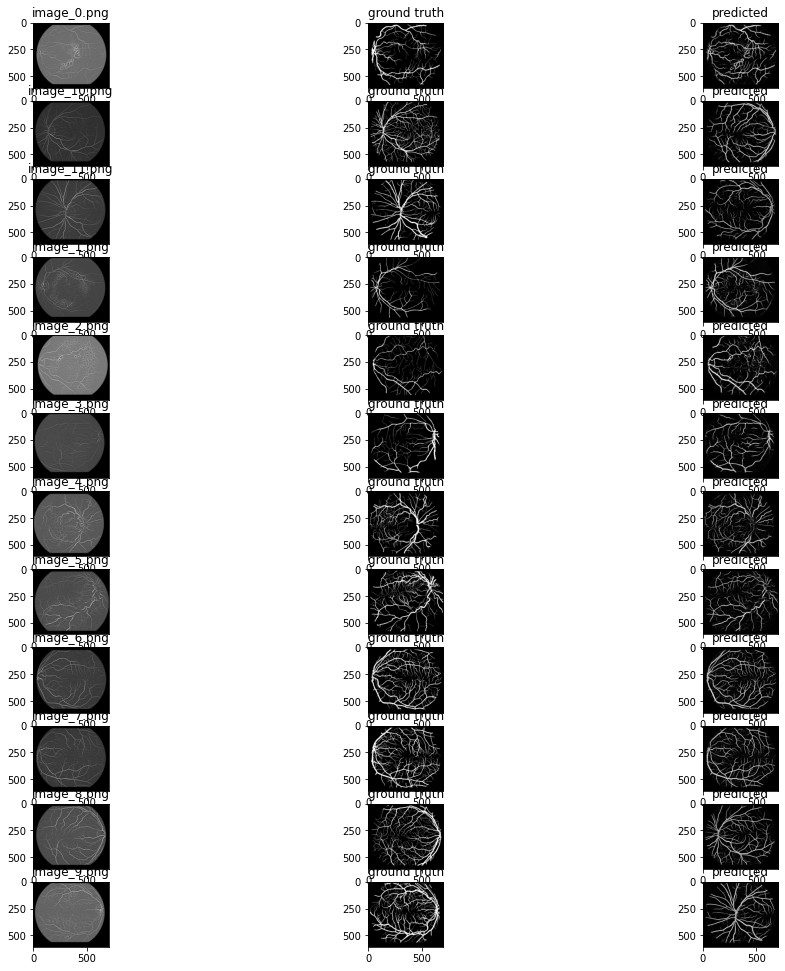

Test images: ['12', '13', '14', '15']
Found 1696 images belonging to 1 classes.
Found 1696 images belonging to 1 classes.
565/565 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9382 - dice_coef: 0.5127 - jacard: 0.3523 - auc_4: 0.9246 - mean_io_u_4: 0.4520 - precision_4: 0.7493 - recall_4: 0.5261Found 4 images belonging to 1 classes.
Found 4 images belonging to 1 classes.


565/565 [==============================] - 931s 2s/step - loss: 0.1693 - accuracy: 0.9382 - dice_coef: 0.5128 - jacard: 0.3523 - auc_4: 0.9247 - mean_io_u_4: 0.4520 - precision_4: 0.7493 - recall_4: 0.5262 - val_loss: 0.2046 - val_accuracy: 0.9271 - val_dice_coef: 0.6196 - val_jacard: 0.4489 - val_auc_4: 0.9566 - val_mean_io_u_4: 0.4309 - val_precision_4: 0.9744 - val_recall_4: 0.4848

Epoch 00001: loss improved from inf to 0.14821, saving model to /content/drive/MyDrive/AI_Projects/STARE/kfold_B/checkpoints/fold_3_unet_stare.hdf5
4/4 [==============================] - 1s 221ms/step


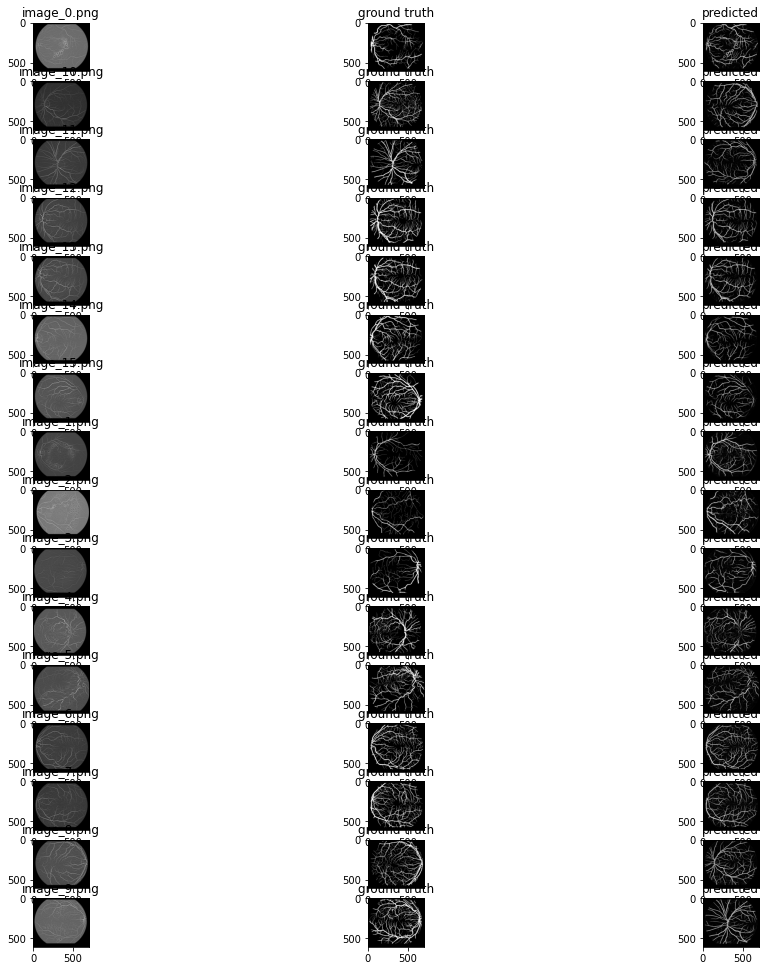

Test images: ['16', '17', '18', '19']
Found 1696 images belonging to 1 classes.
Found 1696 images belonging to 1 classes.
565/565 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9363 - dice_coef: 0.5373 - jacard: 0.3752 - auc_5: 0.9276 - mean_io_u_5: 0.4476 - precision_5: 0.7660 - recall_5: 0.5575Found 4 images belonging to 1 classes.
Found 4 images belonging to 1 classes.


565/565 [==============================] - 931s 2s/step - loss: 0.1743 - accuracy: 0.9363 - dice_coef: 0.5374 - jacard: 0.3753 - auc_5: 0.9277 - mean_io_u_5: 0.4476 - precision_5: 0.7661 - recall_5: 0.5576 - val_loss: 0.1652 - val_accuracy: 0.9440 - val_dice_coef: 0.5678 - val_jacard: 0.3964 - val_auc_5: 0.9500 - val_mean_io_u_5: 0.4516 - val_precision_5: 0.9553 - val_recall_5: 0.4417

Epoch 00001: loss improved from inf to 0.15361, saving model to /content/drive/MyDrive/AI_Projects/STARE/kfold_B/checkpoints/fold_4_unet_stare.hdf5
4/4 [==============================] - 1s 226ms/step


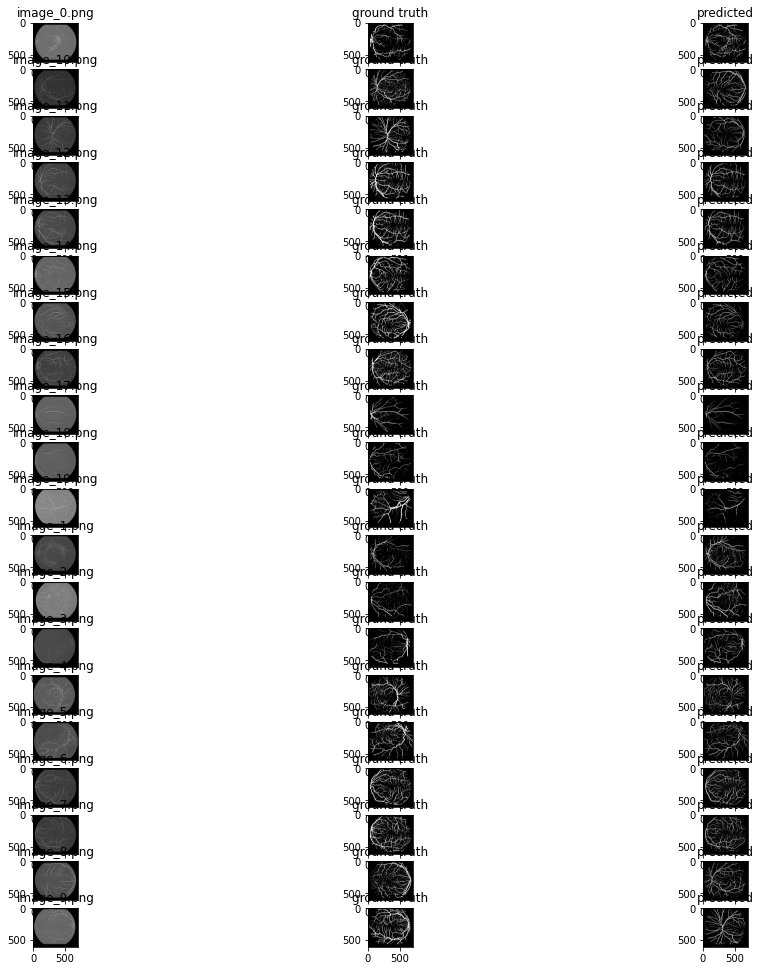

In [ ]:
k_fold(epoch=epoch, 
       start=0, 
       train_batch_size=3, 
       test_batch_size=3, 
       train_sample_number= train_sample_number, 
       test_sample_number=k, 
       initial_model_path = INITIAL_MODEL_PATH, 
       k=k, 
       show_samples=True)

In [ ]:
mean_metrics = np.zeros((1,16))
epoch = 1

for idx,item in enumerate(sorted(os.listdir(LOG_PATH))):
  if '.pkl' in item:
    print("METRICS FOR FOLD {}".format(idx))
    print(50*"-")
    log_file = open(LOG_PATH + "/"+ item, "rb")
    output = pickle.load(log_file)
    i = 0
    for key, value in output.items():
      print(key + " --> " + str(value[epoch-1]))
      mean_metrics[0][i] = mean_metrics[0][i] + value[epoch-1]
      i = i+1
    print(50*"-")

mean_metrics = mean_metrics/5

mean_metrics

METRICS FOR FOLD 0
--------------------------------------------------
loss --> 0.15287882089614868
accuracy --> 0.9442840218544006
dice_coef --> 0.6094112992286682
jacard --> 0.4429204761981964
auc_1 --> 0.9473253488540649
mean_io_u_1 --> 0.4449930191040039
precision_1 --> 0.8170321583747864
recall_1 --> 0.6359742283821106
val_loss --> 0.12856316566467285
val_accuracy --> 0.9510675072669983
val_dice_coef --> 0.5755124688148499
val_jacard --> 0.40401366353034973
val_auc_1 --> 0.9533754587173462
val_mean_io_u_1 --> 0.4633282721042633
val_precision_1 --> 0.6680642366409302
val_recall_1 --> 0.6615098714828491
--------------------------------------------------
METRICS FOR FOLD 1
--------------------------------------------------
loss --> 0.1484060436487198
accuracy --> 0.9460282921791077
dice_coef --> 0.5753424167633057
jacard --> 0.40881577134132385
auc_2 --> 0.9442054033279419
mean_io_u_2 --> 0.4509318768978119
precision_2 --> 0.7976865768432617
recall_2 --> 0.6029617786407471
val_loss --

array([[0.15152481, 0.94476011, 0.58077092, 0.41423336, 0.94399369,
        0.44909847, 0.80058463, 0.60761278, 0.1657433 , 0.9408918 ,
        0.60865045, 0.43819135, 0.95337795, 0.44402957, 0.88743564,
        0.55113098]])